# Destilación paso a paso
### Una guía paso a paso

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/tuning/distilling_step_by_step/distilling_step_by_step.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/tuning/distilling_step_by_step/distilling_step_by_step.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>


| | |
|-|-|
|Autores intelectuales | [Anirudh Haritas Murali](https://github.com/anihm136) |
|Autor de este notebook| [Edison Vazquez](https://github.com/anihm136)|

# Introducción

**Distillation** es una técnica de aprendizaje automático que nos permite extraer los aprendizajes de un modelo grande y representarlos utilizando un modelo más pequeño. Esto permite una mejor escalabilidad, ya que el modelo más pequeño requiere menos recursos para ejecutarse y menos tiempo para generar inferencias y, al mismo tiempo, lograr una precisión cercana a la del modelo más grande.

Un ejemplo temprano de destilación de redes neuronales fue publicado por Jürgen Schmidhuber en 1991, en el campo de las redes neuronales recurrentes (RNN). El problema era la predicción de secuencias para secuencias largas, es decir, aprendizaje profundo. Se resolvió con dos RNN. Una de ellas (el automatizador) predijo la secuencia y otra (el chunker) predijo los errores del automatizador. Simultáneamente, el automatizador predijo los estados internos del chunker. Una vez que el automatizador logra predecir bien los estados internos del chunker, comienza a corregir los errores y pronto el chunker queda obsoleto, dejando solo una RNN al final.

# Formulación

Dado un modelo grande en función de la variable vectorial **x**, entrenado para una tarea de clasificación específica, normalmente la capa final de la red es un softmax en la forma

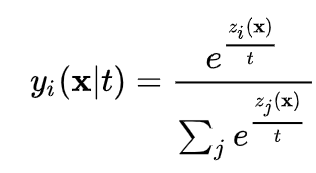

donde **t** es la temperatura, un parámetro que se establece en 1 para un softmax estándar. La temperatura **t** se utiliza para "suavizar" los logits de salida (predicciones en bruto) del modelo del profesor. Esta suavización permite que el modelo del estudiante extraiga más información de la salida del modelo del profesor, en particular sobre la confianza relativa entre clases. El operador softmax convierte los valores logit $z_i(x)$ en pseudoprobabilidades: los valores de temperatura más altos generan distribuciones más suaves de pseudoprobabilidades entre las clases de salida. La destilación de conocimiento consiste en entrenar una red más pequeña, llamada modelo destilado, en un conjunto de datos llamado conjunto de transferencia (que es diferente del conjunto de datos utilizado para entrenar el modelo grande) utilizando la entropía cruzada como la función de pérdida entre la salida del modelo destilado $y(x|t)$ y la salida del modelo grande $\hat{y}(x|t)$ en el mismo registro (o el promedio de las salidas individuales, si el modelo grande es un conjunto), utilizando un valor alto de temperatura $softmax t$ para ambos modelos.

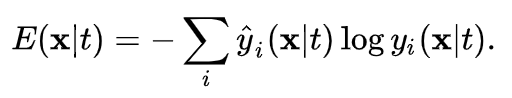

En este contexto, una temperatura alta aumenta la entropía de la salida, por lo que proporciona más información para aprender para el modelo destilado en comparación con los objetivos reales y, al mismo tiempo, reduce la varianza del gradiente entre diferentes registros, lo que permite una mayor tasa de aprendizaje.

Si se dispone de la verdad fundamental/razonamiento para el conjunto de transferencia, el proceso se puede fortalecer agregando a la pérdida la entropía cruzada entre la salida del modelo destilado (calculada con $t$ = 1), y la etiqueta conocida y



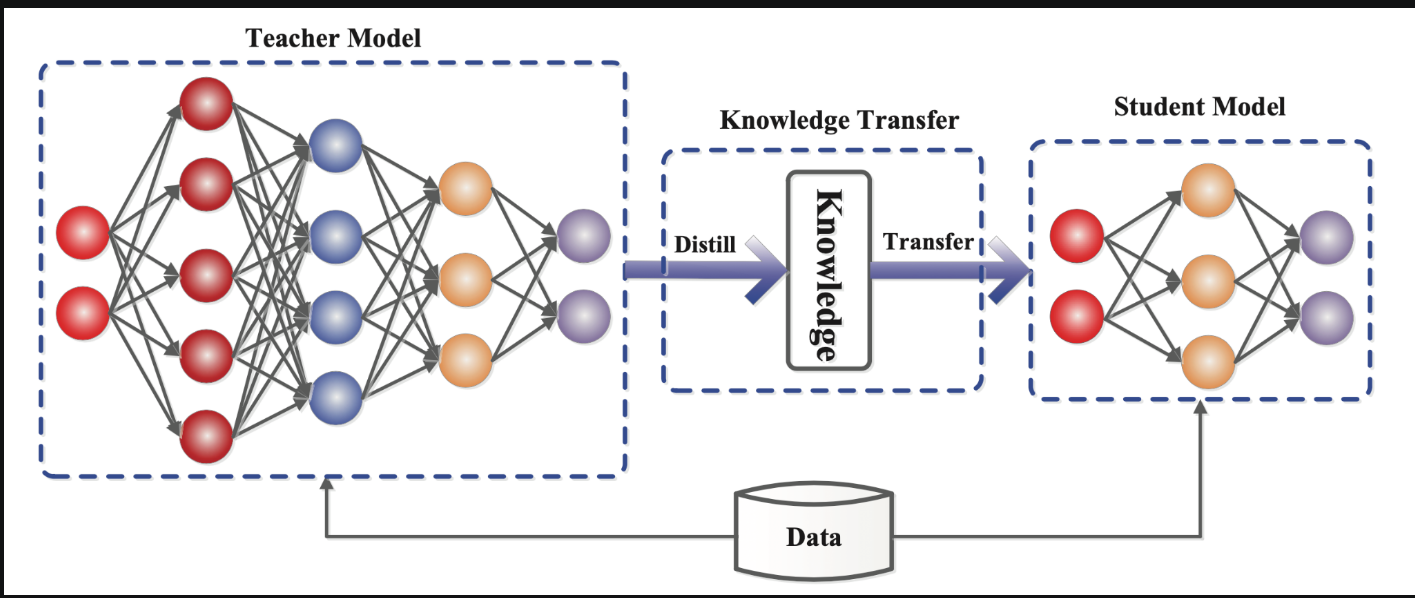



Tradicionalmente, la destilación utiliza los parámetros internos del modelo más grande (específicamente, los logits) para entrenar el modelo más pequeño. Sin embargo, algunos de los modelos de lenguaje grandes con mejor rendimiento en la actualidad, incluido el modelo [PaLM 2](https://ai.google/discover/palm2/) de Google, se exponen a los consumidores como una API, sin medios para acceder a los parámetros internos. Hasta hace poco, esto ha prohibido el uso de estos modelos como modelos de enseñanza para la destilación.

## Objetivos
En este cuaderno, repasaremos la técnica descrita en el artículo [Distilling step-by-step](https://blog.research.google/2023/09/distilling-step-by-step-outperforming.html), que describe un enfoque novedoso para destilar el conocimiento de un LLM grande en un LLM más pequeño sin requerir los parámetros internos del modelo más grande. El código original de la investigación está disponible en [https://github.com/google-research/distilling-step-by-step](https://github.com/google-research/distilling-step-by-step).

Repasaremos cada paso del entrenamiento de un modelo pequeño (estudiante) para imitar la capacidad de razonamiento de un modelo más grande (profesor). Al entrenar el modelo del estudiante para que imite la capacidad de razonamiento en lugar de los resultados reales, podemos hacer que el modelo más pequeño se generalice mejor a otras entradas invisibles.

Los pasos que se llevan a cabo incluyen:

- Preparar un conjunto de datos para la destilación
- Configurar una secuencia de destilación
- Entrenar un modelo de estudiante utilizando PaLM como modelo de docente
- Evaluar el rendimiento del modelo destilado


# Inicio

## (Solo en Colab) Autenticarse como usuario
En Colab, nos autenticaremos como un usuario que tiene acceso a los recursos de Google Cloud mencionados anteriormente. Esto será necesario cuando implementemos el modelo

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth


    auth.authenticate_user()

## Descargar archivos de apoyo ***(No ejecutar)***
Para simplificar el proceso de ejecución de esta demostración, se proporcionan algunos archivos de apoyo (salidas de PaLM para el conjunto de datos y código para crear el contenedor de servicio del modelo)

In [3]:
! wget https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/language/tuning/distilling_step_by_step/requirements.txt
! wget https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/language/tuning/distilling_step_by_step/prediction_container/Dockerfile -P prediction_container
! wget https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/language/tuning/distilling_step_by_step/prediction_container/app/main.py -P prediction_container/app
! wget https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/language/tuning/distilling_step_by_step/prediction_container/app/requirements.txt -P prediction_container/app
! wget https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/language/tuning/distilling_step_by_step/prediction_container/app/requirements-torch.txt -P prediction_container/app
! wget https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/language/tuning/distilling_step_by_step/prediction_container/app/prestart.sh -P prediction_container/app

Copying gs://github-repo/distillation/PaLM_CoT_train.json...
Copying gs://github-repo/distillation/PaLM_CoT_test.json...
Copying gs://github-repo/distillation/prediction_container/Dockerfile...
Copying gs://github-repo/distillation/requirements.txt...
Copying gs://github-repo/distillation/prediction_container/app/main.py...
Copying gs://github-repo/distillation/prediction_container/app/prestart.sh...
Copying gs://github-repo/distillation/prediction_container/app/requirements-torch.txt...
Copying gs://github-repo/distillation/prediction_container/app/requirements.txt...
--2025-04-24 01:05:58--  https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/tree/main/language/tuning/distilling_step_by_step/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response...

## Instalar las bibliotecas necesarias

In [ ]:
! gsutil -m cp -r gs://github-repo/distillation/* .

In [4]:
! pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Habilitar las API de Google Cloud requeridas
Para facilitar la limpieza de recursos, puede crear un nuevo proyecto y eliminarlo al final de este tutorial

Las API de Google Cloud proporcionan la infraestructura necesaria para tareas como alojar el modelo, administrar datos y ejecutar cálculos. El repositorio sugiere crear un proyecto de Google Cloud para administrar los recursos fácilmente, lo que le permite limpiar o eliminar el proyecto una vez que se complete la demostración. Esta compatibilidad hace que el proceso de implementación sea más manejable.

In [5]:
PROJECT = "DL-Avanzado"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

In [6]:
!gcloud projects list

PROJECT_ID                 NAME             PROJECT_NUMBER
stellar-chemist-436623-p8  Distilling LLMs  946161384147
w1sep-361903               W1SEP            948070162239


In [7]:
!gcloud config set project stellar-chemist-436623-p8

Updated property [core/project].


In [8]:
!gcloud services enable aiplatform.googleapis.com --project {'stellar-chemist-436623-p8'}
!gcloud services enable artifactregistry.googleapis.com --project {'stellar-chemist-436623-p8'}
!gcloud services enable cloudbuild.googleapis.com --project {'stellar-chemist-436623-p8'}

# Paso 1: Preparación de datos

Nuestro conjunto de datos necesitará tres campos:
1. Un mensaje de entrada para el LLM
2. Una etiqueta de verdad fundamental, que es el resultado esperado
3. Un 'razonamiento', que es el razonamiento generado por el modelo del maestro (usando el mensaje de CoT)

Aquí, usaremos el conjunto de datos [Explicaciones de sentido común](https://huggingface.co/datasets/cos_e) de Hugging Face para entrenar a nuestro modelo de estudiante. Este conjunto de datos contiene alrededor de 10 000 muestras de entrenamiento y 1200 muestras de prueba.

In [9]:
from huggingface_hub import login

In [10]:
from typing import Any

from datasets import DatasetDict, load_dataset

In [11]:
SOURCE_DATASET = "cos_e"  # @param {type:"string"}
SOURCE_DATASET_VERSION = "v1.11"  # @param {type:"string"}

dataset = load_dataset(SOURCE_DATASET, SOURCE_DATASET_VERSION)
dataset["test"] = dataset["validation"]
del dataset["validation"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.87k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/222k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'choices', 'answer', 'abstractive_explanation', 'extractive_explanation'],
        num_rows: 9741
    })
    test: Dataset({
        features: ['id', 'question', 'choices', 'answer', 'abstractive_explanation', 'extractive_explanation'],
        num_rows: 1221
    })
})

In [13]:
def prepare_input(example: dict[str, Any]) -> dict[str, Any]:
    question = example["question"]
    c_0 = example["choices"][0]
    c_1 = example["choices"][1]
    c_2 = example["choices"][2]
    c_3 = example["choices"][3]
    c_4 = example["choices"][4]

    input = f"{question}\nAnswer Choices:\n(a) {c_0}\n(b) {c_1}\n(c) {c_2}\n(d) {c_3}\n(e) {c_4}"

    example["input"] = input
    example["label"] = example["answer"]

    return example


dataset = dataset.map(
    prepare_input,
    remove_columns=[
        "id",
        "question",
        "choices",
        "answer",
        "abstractive_explanation",
        "extractive_explanation",
    ],
)

Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [15]:
dataset['train']['input']

['"There are 10 apples on an apple tree.  Three fall off.  Now there are X apples."  What is this an example of?\nAnswer Choices:\n(a) park\n(b) coloring book\n(c) garden center\n(d) math problem\n(e) gravity',
 'A John is a bum.  Much like the stereotype, he lives near this sort of transportation infrastructure. Where does he live?\nAnswer Choices:\n(a) bus depot\n(b) beach\n(c) train station\n(d) bridge\n(e) bridge',
 'A bad person places little value on being honest, acting without pretense or being what?\nAnswer Choices:\n(a) excellent\n(b) upright\n(c) premium\n(d) competent\n(e) sincere',
 'A bald eagle flies over St. Paul, where is it?\nAnswer Choices:\n(a) texas\n(b) thermal\n(c) minnesota\n(d) canada\n(e) photograph',
 'A battleship is a powerful vessel.  If you need something similar but faster, what would you use?\nAnswer Choices:\n(a) yatch\n(b) corvette\n(c) aircraft carrier\n(d) destroyer\n(e) patrol boat',
 'A beaver is taking logs from a Pacific beach, where is it locat

Por otra parte, existen los resultados generados por el modelo PaLM (modelo LLM). Estos resultados se almacenan normalmente en un archivo JSON y pueden contener entradas, etiquetas previstas y fundamentos (el razonamiento detrás de las predicciones).

El modelo PaLM (Pathways Language Model) se utiliza como un modelo maestro

In [16]:
LLM_OUTPUTS_FILE_PREFIX = "PaLM_CoT"  # @param {type:"string"}
LLM_OUTPUTS_FILE = LLM_OUTPUTS_FILE_PREFIX + "_{split}.json"


def add_llm_outputs(dataset: DatasetDict, split: str) -> None:
    llm_ds = load_dataset("json", data_files=LLM_OUTPUTS_FILE.format(split=split))[
        "train"
    ]

    print(llm_ds)

    def _add(example: dict[str, Any], idx: int) -> dict[str, Any]:
        example["llm_rationale"] = llm_ds[idx]["rationale"]
        example["llm_label"] = llm_ds[idx]["label"]
        return example

    dataset[split] = dataset[split].map(_add, with_indices=True)


for split in ["train", "test"]:
    add_llm_outputs(dataset, split)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['rationale', 'label'],
    num_rows: 9741
})


Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['rationale', 'label'],
    num_rows: 1221
})


Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [20]:
dataset['train']['label']

['math problem',
 'bridge',
 'sincere',
 'minnesota',
 'corvette',
 'washington',
 'city',
 'in charge of project',
 'punishment',
 'marriage',
 'meadow',
 'heading north',
 'meow',
 'residential area',
 'comfortable position',
 'gather flowers',
 'aquarium',
 'back and',
 'believe in god',
 'vagina',
 'ocean',
 'rural area',
 'nursery rhyme',
 'front back',
 'logging camp',
 'ask questions',
 'garbage',
 'will to survive',
 'capsule',
 'northern hemisphere',
 'boy',
 'blooms',
 'flowerpot',
 'liquid',
 'suck blood',
 'california',
 'say hello',
 'house',
 'meditation center',
 'big house',
 'overeating',
 'hear sounds',
 'hockey game',
 'fairy tale',
 'english hunt',
 'have fever',
 'one body',
 'new jersey',
 'department store',
 'fair',
 'table',
 'gum tree',
 'san diego zoo',
 'warehouse',
 'getting work done',
 'expiration',
 'unhappy',
 'sore feet',
 'pick up',
 'office',
 'watch television',
 'atlas',
 'law office',
 'trunk',
 'in wild',
 'another place',
 'tropical areas',
 'fr

Estas son los labels que el modelo estudiante utilizará para ser entrenado

In [18]:
*dataset['train']['llm_label']

['math problem',
 'train station',
 'sincere',
 'minnesota',
 'destroyer',
 'canada',
 'public place',
 'in charge of project',
 'punishment',
 'marriage',
 'meadow',
 'heading north',
 'meow',
 'residential area',
 'upside down',
 'gather flowers',
 'aquarium or',
 'tally back',
 'believe in god',
 'vagina',
 'ocean',
 'rural area',
 'nursery rhyme',
 'corner',
 'logging camp',
 'investigate',
 'garbage',
 'will to survive',
 'capsule',
 'northern hemisphere',
 'boy',
 'blooms',
 'flowerpot',
 'liquid',
 'suck blood',
 'california',
 'say hello',
 'house',
 'meditation center',
 'palace',
 'overeating',
 'hear sounds',
 'hockey game',
 'advice',
 'english hunt',
 'have fever',
 'one body',
 'new jersey',
 'department store',
 'fair',
 'library',
 'gum tree',
 'england',
 'warehouse',
 'paperwork',
 'expiration',
 'end pain',
 'wonder',
 'pick up',
 'office',
 'watch television',
 'map',
 'law office',
 'trunk',
 'zoo',
 'the zoo',
 'tropical areas',
 'French government',
 'disaster',


# Paso 2: Construir el modelo estudiante

In [21]:
import pandas as pd
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
)

Aquí, utilizaremos el modelo T5 como base entrenada previamente para la destilación y utilizaremos el tokenizador correspondiente. Puede utilizar un modelo entrenado previamente diferente (y el tokenizador correspondiente) cambiando el nombre del modelo a continuación por un modelo diferente en Hugging Face Hub, o utilizar un modelo personalizado/entrenar un tokenizador desde cero en su propio conjunto de datos. Tenga en cuenta que necesitará muchos más datos y cálculos para entrenar un buen modelo desde cero.

T5 is available in multiple sizes, including: T5 Small, T5 Base, T5 Large, T5 3B, T5 11B

In [22]:
PRETRAINED_BASE_MODEL = "google/flan-t5-base"  # @param {type:"string"}
MAX_INPUT_LENGTH = 1024  # @param {type:"integer"} ## tokens
MAX_OUTPUT_LENGTH = 256  # @param {type:"integer"} ## tokens

In [23]:
PRETRAINED_BASE_MODEL

'google/flan-t5-base'

## a) Preparar el tokenizador y tokenizar el conjunto de datos

El fragmento de código proporcionado define una función para tokenizar su conjunto de datos utilizando el tokenizador Hugging Face para el modelo preentrenado especificado (en este caso, google/flan-t5-base).

Esta línea inicializa el tokenizador para el modelo entrenado previamente especificado. Se encargará de convertir las entradas de texto a un formato adecuado para el modelo (tokens).

In [24]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_BASE_MODEL)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [25]:
def tokenize_function(examples: dict[str, list[Any]]):

    ''' La función crea entradas de modelo anteponiendo la frase "predict: " a cada texto de entrada.
    Utiliza el tokenizador para codificar estas entradas modificadas en identificadores de token,
    limitando la longitud a MAX_INPUT_LENGTH y truncando cualquier texto que supere esta longitud.'''

    model_inputs = tokenizer(
        ["predict: " + text for text in examples["input"]],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )

    '''
    De manera similar, esta parte crea entradas para la tarea de explicación al anteponer "explain: " a cada texto de entrada.
    Codifica estas entradas con el mismo proceso de tokenización que el anterior.
    '''
    expl_model_inputs = tokenizer(
        ["explain: " + text for text in examples["input"]],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )

    '''
    Para una oración de entrada como "predecir: ¿Cuál es la capital de Francia?",
    el tokenizador convierte esta oración en input_ids de la siguiente manera:
    [101, 12345, 456, 7890, 2345, 678, 1234, 2345]
    '''

    '''
    La máscara de atención es un tensor binario que indica qué tokens debe atender (procesar) el modelo y
    cuáles debe ignorar (por ejemplo, los tokens de relleno). Ayuda al modelo a diferenciar entre tokens reales y de relleno.

    Para la misma oración de entrada, si el tokenizador agrega relleno para garantizar que
    la longitud de entrada sea consistente, la máscara de atención podría verse así:

    [1,0,0,1,0,1]
    '''
    model_inputs["expl_input_ids"] = expl_model_inputs["input_ids"]
    model_inputs["expl_attention_mask"] = expl_model_inputs["attention_mask"]

    # Codificar la etiqueta de destino y la justificación del destino
    label_output_encodings = tokenizer(
        text_target=examples["label"], max_length=MAX_OUTPUT_LENGTH, truncation=True
    )

    rationale_output_encodings = tokenizer(
        text_target=examples["llm_rationale"],
        max_length=MAX_OUTPUT_LENGTH,
        truncation=True,
    )

    model_inputs["labels"] = label_output_encodings["input_ids"]
    model_inputs["expl_labels"] = rationale_output_encodings["input_ids"]

    return model_inputs


tokenized_dataset = dataset.map(
    tokenize_function,
    remove_columns=["input", "llm_rationale", "label", "llm_label"],
    batched=True,
)

Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [29]:
tokenized_dataset['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'expl_input_ids', 'expl_attention_mask', 'labels', 'expl_labels'],
    num_rows: 9741
})

In [25]:
tokenized_dataset['train']['labels']

[[7270, 682, 1],
 [4716, 1],
 [437, 60, 1],
 [3519, 1496, 32, 17, 9, 1],
 [4301, 19828, 1],
 [6179, 6029, 1],
 [690, 1],
 [16, 1567, 13, 516, 1],
 [19372, 1],
 [5281, 1],
 [140, 9, 15198, 1],
 [6904, 3457, 1],
 [140, 2381, 1],
 [4326, 616, 1],
 [1965, 1102, 1],
 [7479, 3652, 1],
 [24633, 1],
 [223, 11, 1],
 [857, 16, 8581, 1],
 [409, 19604, 1],
 [5431, 1],
 [5372, 616, 1],
 [17354, 31294, 1],
 [851, 223, 1],
 [3, 12578, 2856, 1],
 [987, 746, 1],
 [12937, 1],
 [56, 12, 7905, 1],
 [13445, 1],
 [8390, 3, 6015, 23, 9475, 1],
 [4940, 1],
 [13081, 7, 1],
 [5624, 3013, 1],
 [4400, 1],
 [3, 7, 4636, 1717, 1],
 [3, 15534, 1161, 29, 23, 9, 1],
 [497, 21820, 1],
 [629, 1],
 [10412, 1530, 1],
 [600, 629, 1],
 [147, 15, 1014, 1],
 [1616, 2993, 1],
 [16528, 467, 1],
 [19270, 5221, 1],
 [22269, 8069, 1],
 [43, 17055, 1],
 [80, 643, 1],
 [126, 13426, 1],
 [3066, 1078, 1],
 [2725, 1],
 [953, 1],
 [11406, 2195, 1],
 [3, 7, 152, 67, 839, 3, 172, 32, 32, 1],
 [11625, 1],
 [652, 161, 612, 1],
 [8982, 257, 

## b) Preparar el modelo estudiante

In [30]:
model = AutoModelForSeq2SeqLM.from_pretrained(PRETRAINED_BASE_MODEL)
# Uncomment if you have more than one GPU to enable parallelism
# model.parallelize()

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

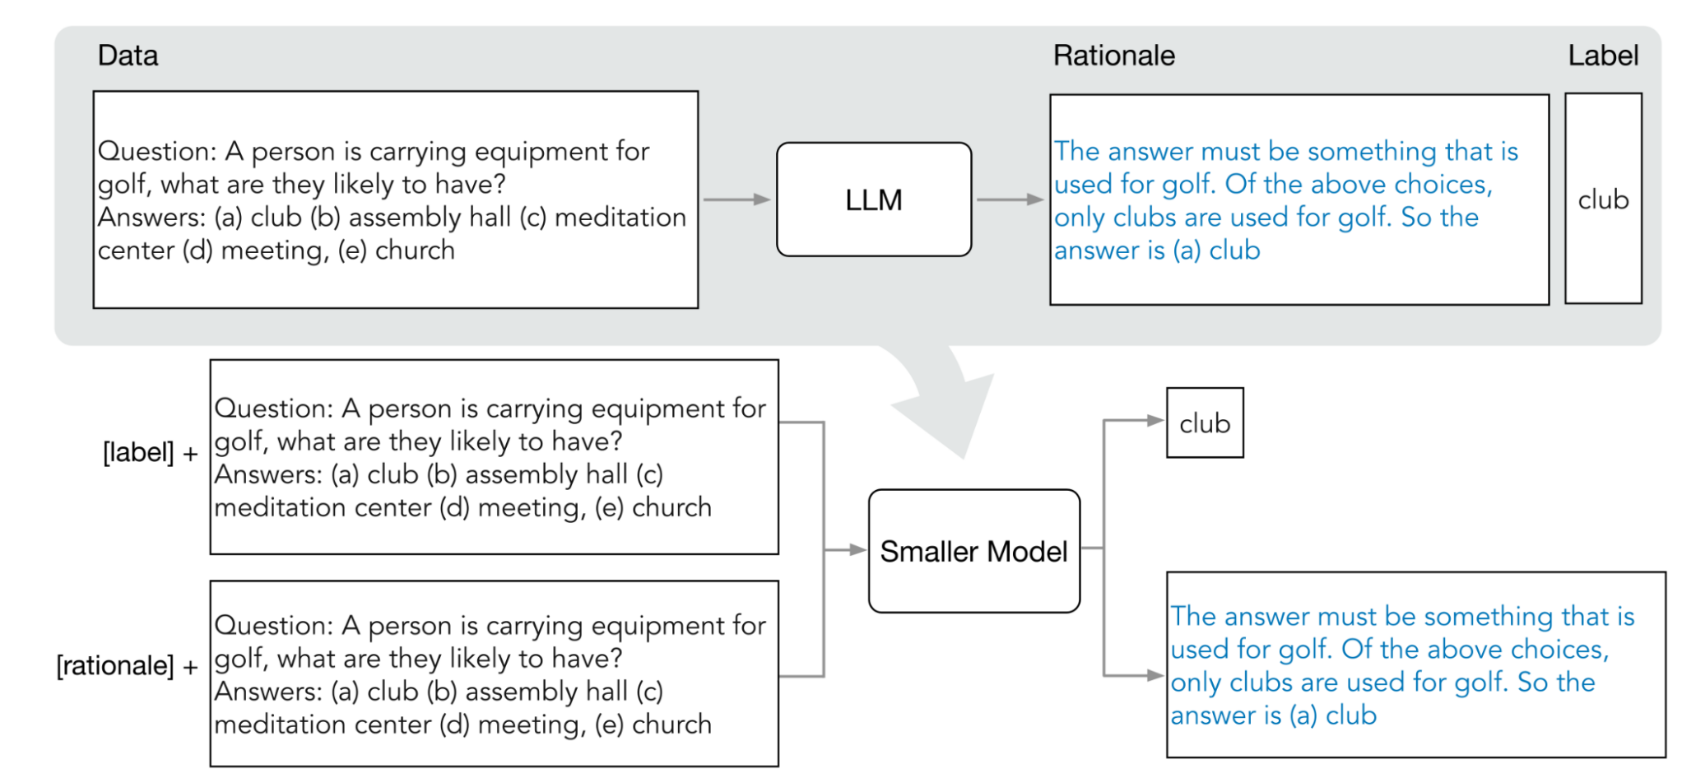

## c) Preparar el recopilador de datos para el entrenamiento multitarea
Dado que necesitamos generar predicciones tanto para la respuesta como para los fundamentos en cada paso de entrenamiento y predicción, utilizaremos un recopilador de datos personalizado que tomará cada lote de características y devolverá dos conjuntos de características y etiquetas, uno para la respuesta y otro para la justificación

In [31]:
class TaskPrefixDataCollator(DataCollatorForSeq2Seq):
    def __call__(self, features, return_tensors=None):
        features_df = pd.DataFrame(features)
        '''
        El código extrae columnas relevantes para las características de respuesta (etiquetas, input_ids, attention_mask) y
        las convierte nuevamente a un formato de diccionario usando to_dict("records").

        dado que el modelo estará recibiendo dos inputs para evitar utilizar otro mapping solo se renombra las features de explicación
        '''
        # Generar funciones para las respuestas
        ans_features = features_df.loc[
            :, features_df.columns.isin(["labels", "input_ids", "attention_mask"])
        ].to_dict("records")
        ans_features = super().__call__(ans_features, return_tensors)

        # Generar características para explicaciones
        expl_features = (
            features_df.loc[
                :,
                features_df.columns.isin(
                    ["expl_labels", "expl_input_ids", "expl_attention_mask"]
                ),
            ]
            .rename(
                columns={
                    "expl_labels": "labels",
                    "expl_input_ids": "input_ids",
                    "expl_attention_mask": "attention_mask",
                }
            )
            .to_dict("records")
        )
        expl_features = super().__call__(expl_features, return_tensors)

        return {
            "ans": ans_features,
            "expl": expl_features,
        }


data_collator = TaskPrefixDataCollator(tokenizer=tokenizer, model=model)

## d) Preparar el entrenador para el entrenamiento multitarea
De manera similar, utilizaremos un entrenador personalizado para entrenar el modelo, que tiene en cuenta tanto las pérdidas por generación de respuestas como por generación de razonamiento. La pérdida de generación de razonamiento permite que el modelo
aprenda a generar los pasos de razonamiento intermedios
para la predicción y, por lo tanto, podría guiar al
modelo para predecir mejor la etiqueta resultante. Esta
es nuestra propuesta de destilación paso a paso. Utilizaremos un hiperparámetro `alpha` para controlar la contribución relativa de las dos pérdidas a la pérdida general del modelo

La función de pérdida general es:

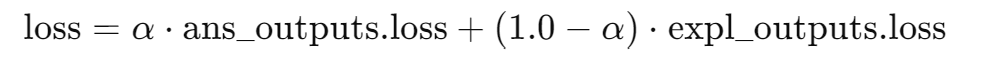

In [32]:
class TaskPrefixTrainer(Seq2SeqTrainer):
    def __init__(self, alpha, output_rationale, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.output_rationale = output_rationale

    def compute_loss(self, model, inputs,num_items_in_batch=None, return_outputs=False):
        ans_outputs = model(**inputs["ans"])
        expl_outputs = model(**inputs["expl"])

        loss = self.alpha * ans_outputs.loss + (1.0 - self.alpha) * expl_outputs.loss

        return (
            (loss, {"ans": ans_outputs, "expl": expl_outputs})
            if return_outputs
            else loss
        )

#### Lo podemos utilizar de una manera manual *** Si estamos creando nuestro propio trainer, es necesario utilizarlo
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        ans_outputs = super().prediction_step(
            model, inputs["ans"], prediction_loss_only=False, ignore_keys=ignore_keys
        )
        if self.output_rationale:
            expl_outputs = super().prediction_step(
                model,
                inputs["expl"],
                prediction_loss_only=False,
                ignore_keys=ignore_keys,
            )
        else:
            expl_outputs = ans_outputs  # placeholder only

        loss = self.alpha * ans_outputs[0] + (1 - self.alpha) * expl_outputs[0]

        return (
            loss,
            [ans_outputs[1], expl_outputs[1]],
            [ans_outputs[2], expl_outputs[2]],
        )

# Paso 3: Entrenar el modelo

In [33]:
import numpy as np
from transformers import Seq2SeqTrainingArguments
from transformers.trainer_utils import set_seed

In [34]:
RUN_ID = 0  # @param {type:"integer"}
CONFIG_DIR = "distillation_outputs"  # @param {type:"string"}
CKPT_DIR = f"{CONFIG_DIR}/ckpts/{RUN_ID}"  # for model checkpoints
LOG_DIR = f"{CONFIG_DIR}/logs/{RUN_ID}"  # for training logs

EVAL_STEPS = 500  # @param {type:"integer"}
SAVE_STEPS = 1000  # @param {type:"integer"}
MAX_STEPS = 4000  # @param {type:"integer"}


LEARNING_RATE = 5e-5
BATCH_SIZE = 16

ALPHA = 0.7 ### El hiper-parametro de la contribución relativa de mis predicciones (labels + explicación-rh)

In [35]:
set_seed(RUN_ID)

training_args = Seq2SeqTrainingArguments(
    CKPT_DIR,
    remove_unused_columns=False,
    eval_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    logging_dir=LOG_DIR,
    logging_strategy="steps",
    logging_steps=EVAL_STEPS,
    max_steps=MAX_STEPS,
    learning_rate=LEARNING_RATE,
    gradient_accumulation_steps=1,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    seed=RUN_ID,
    local_rank=-1,
    bf16=False,
    generation_max_length=64,
    prediction_loss_only=False,
)

In [37]:
from collections.abc import Callable

from transformers import AutoTokenizer

def compute_metrics_text(tokenizer: AutoTokenizer) -> Callable:
    def compute_metrics(eval_pred: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
        predictions, labels = eval_pred
        decoded_preds = tokenizer.batch_decode(predictions[0], skip_special_tokens=True)

        labels = np.where(labels[0] != -100, labels[0], tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        acc = np.mean(np.array(decoded_preds) == np.array(decoded_labels))

        return {"accuracy": acc}

    return compute_metrics


compute_metrics = compute_metrics_text(tokenizer)

In [38]:
trainer_kwargs = {
    "alpha": ALPHA,
    "output_rationale": False,
    "model": model,
    "args": training_args,
    "train_dataset": tokenized_dataset["train"],
    "eval_dataset": {
        "test": tokenized_dataset["test"],
    },
    "data_collator": data_collator,
    "tokenizer": tokenizer,
    "compute_metrics": compute_metrics,
}

In [39]:
trainer = TaskPrefixTrainer(**trainer_kwargs)
trainer.train()




<ipython-input-32-a7f10a96b4d7>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `TaskPrefixTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vazquezedison (vazquezedison-centro-de-investigaci-n-en-matematicas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Test Loss,Test Accuracy
500,0.470200,No log,0.362570,0.732187
1000,0.351300,No log,0.376921,0.722359
1500,0.306700,No log,0.413716,0.722359
2000,0.271800,No log,0.444275,0.729730
2500,0.251300,No log,0.421733,0.742834


Step,Training Loss,Validation Loss,Test Loss,Test Accuracy
500,0.470200,No log,0.362570,0.732187
1000,0.351300,No log,0.376921,0.722359
1500,0.306700,No log,0.413716,0.722359
2000,0.271800,No log,0.444275,0.729730
2500,0.251300,No log,0.421733,0.742834
3000,0.232200,No log,0.450996,0.741196
3500,0.215800,No log,0.476236,0.733006
4000,0.209400,No log,0.459886,0.730549


TrainOutput(global_step=4000, training_loss=0.28858602142333983, metrics={'train_runtime': 3352.1282, 'train_samples_per_second': 19.092, 'train_steps_per_second': 1.193, 'total_flos': 0.0, 'train_loss': 0.28858602142333983, 'epoch': 6.568144499178982})

# Paso 4: Evaluar el modelo

Ahora comparemos el rendimiento de nuestro modelo de estudiante simplificado con el del modelo PaLM. También intentaremos generar resultados a partir del modelo de estudiante base para comparar la diferencia que ha logrado el método de entrenamiento simplificado.

In [ ]:
from transformers import pipeline

In [ ]:
CHECKPOINT = f"{CKPT_DIR}/checkpoint-4000"

distilled_tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
distilled_model = AutoModelForSeq2SeqLM.from_pretrained(CHECKPOINT)

base_tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_BASE_MODEL)
base_model = AutoModelForSeq2SeqLM.from_pretrained(PRETRAINED_BASE_MODEL)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
distill_generator = pipeline(
    "text2text-generation", model=distilled_model, tokenizer=distilled_tokenizer
)
base_generator = pipeline(
    "text2text-generation", model=base_model, tokenizer=base_tokenizer
)


def generate_answers(sample: dict[str, Any]) -> dict[str, Any]:
    sample["distill_label"] = distill_generator(["predict: " + sample["input"]])[0][
        "generated_text"
    ]
    sample["base_label"] = base_generator(sample["input"])[0]["generated_text"]
    return sample


output_dataset = dataset["test"].map(generate_answers)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
output_df = output_dataset.to_pandas().drop("llm_rationale", axis=1)
display_df = output_df.copy().rename(
    columns={
        "input": "Question",
        "label": "True answer",
        "llm_label": "PaLM answer",
        "base_label": "T5 answer",
        "distill_label": "Distilled T5 answer",
    }
)
display_df.head(10)

,Question,True answer,PaLM answer,Distilled T5 answer,T5 answer
0,"A beaver is know for building prowess, their s...",wooded area,wooded area,wooded area,(c)
1,A car was hailed to chauffeur someone to the o...,go downtown,go downtown,go downtown,(a)
2,"A child wants to play, what would they likely ...",play tag,play tag,play tag,(c)
3,"A farmer sees a weasel in the woods, where is ...",great outdoors,great outdoors,great outdoors,(d)
4,"A gentleman is carrying equipment for golf, wh...",club,club,club,(a)
5,"A human wants to submerge himself in water, wh...",whirlpool bath,whirlpool bath,whirlpool bath,(a)
6,"A loud machine is irritating, but many are exp...",industrial area,industrial area,laboratory,(e)
7,A man takes a seat at a museum outside of Barc...,martorell,show,martorell,(b)
8,A man wants air conditioning while we watches ...,house,house,movie theatre,(e)
9,A patriotic guy with a camera is looking for a...,photograph,photograph,photograph,(e)


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('T5 answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
print(
    "The accuracy of PaLM model is {:.2f}%".format(
        output_df[output_df["label"] == output_df["llm_label"]]["label"].count()
        / len(output_df)
        * 100
    )
)
print(
    "The accuracy of raw student model is {:.2f}%".format(
        output_df[output_df["label"] == output_df["base_label"]]["label"].count()
        / len(output_df)
        * 100
    )
)
print(
    "The accuracy of distilled student model is {:.2f}%".format(
        output_df[output_df["label"] == output_df["distill_label"]]["label"].count()
        / len(output_df)
        * 100
    )
)

The accuracy of PaLM model is 77.23%
The accuracy of raw student model is 0.25%
The accuracy of distilled student model is 73.22%


Como podemos ver, el modelo de estudiante preentrenado en bruto no puede generar respuestas. Sin embargo, con solo unas pocas muestras y épocas de entrenamiento, podemos aproximarnos a la precisión del modelo PaLM utilizando el modelo T5, mucho más pequeño.

In [ ]:
model = aiplatform.Model(model.resource_name)

endpoint = model.deploy(
    machine_type="n1-standard-4",
    traffic_split={"0": 100},
    min_replica_count=1,
    max_replica_count=1,
    accelerator_type="NVIDIA_TESLA_T4",
    accelerator_count=1,
    traffic_percentage=100,
    deploy_request_timeout=1200,
    sync=True,
)
endpoint.wait()

# Resumen
En este cuaderno, hemos aprendido cómo podemos usar un LLM de un profesor grande para enseñar a un LLM de un estudiante más pequeño a razonar como él, lo que mejora enormemente el rendimiento de los modelos más pequeños en comparación con el ajuste simple de instrucciones.

Si está interesado en ejecutar una secuencia de destilación similar en los LLM disponibles en Google Cloud, consulte [Destilación de modelos de texto en Google Cloud](https://cloud.google.com/vertex-ai/docs/generative-ai/models/distill-text-models/)